In [1]:
from utils_v1 import *


In [2]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential
import src.trainer.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric


In [3]:
from enum import Enum
UncertaintyMethod = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
uncertaintyMethod = "evidential"


In [4]:

config = {
	"training": True,
	"learning_rate": 1e-4, # 1e-3
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": uncertaintyMethod,
	"evidence_function": evidential.softsign_evidence
}

'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = config['addPastDeforestationInput'],
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

# exp = 170
# exp = 155
exp = 174



# if config["training"] == True:
trainer = TrainerEvidential(config, dataset, patchesHandler)

trainer.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [5]:
exp

173

In [6]:
trainer.setExperimentPath()
trainer.createLogFolders()

In [7]:
# ic(type(dataset), exp, dataset.dates)


In [8]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [9]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [10]:

trainer.label_mask.dtype

dtype('uint8')

In [11]:

trainer.getLabelCurrentDeforestation()

In [12]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [13]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

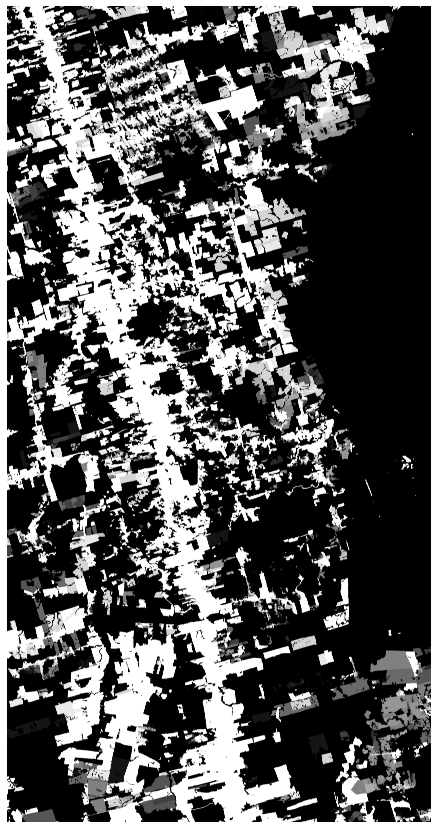

In [14]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [15]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [16]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [17]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


ic| im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (17730, 9200, 2), im_idx.dtype: dtype('uint16')


In [18]:
if config["training"] == True:
    trainer.extractCoords()

ic| coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (110896, 2), coords.dtype: dtype('uint16')


In [19]:
if config["training"] == True:
    trainer.trainTestSplit()

ic| self.coords_train.shape: (41812, 3)
    self.coords_val.shape: (10260, 3)


In [20]:
if config["training"] == True:
    trainer.label_mask.shape

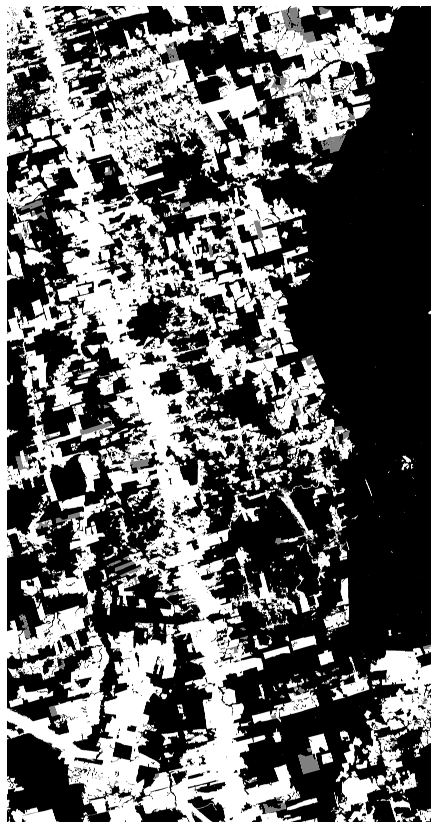

In [21]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [22]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [23]:
if config["training"] == True:
    print(trainer.coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [17594  8968     0]
 [17594  9006     0]
 [17594  9044     0]]


In [24]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

training samples:  (3753, 3) validation samples:  (1032, 3)


In [25]:
if config["training"] == True:
    inputSnipShow = True

ic| np.mean(image_patch[...,[1,2,3]]): 0.107682176
    np.mean(image_patch[...,[11,12,13]]): 0.22637562


[12084  2508     0]


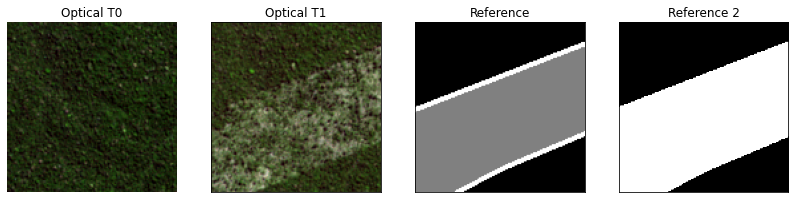

In [26]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


ic| np.mean(image_patch[...,[1,2,3]]): 0.2714837
    np.mean(image_patch[...,[11,12,13]]): 0.30292988
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 114 5928    0]


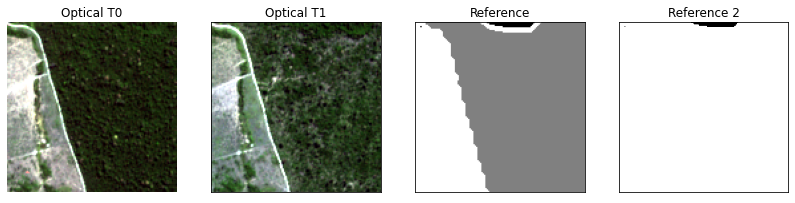

In [27]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


ic| np.mean(image_patch[...,[1,2,3]]): 0.15096879
    np.mean(image_patch[...,[11,12,13]]): 0.103304155


[3382 2128    0]


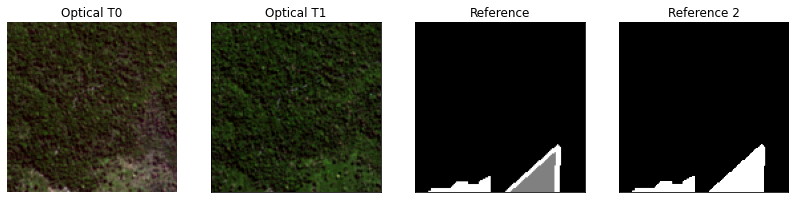

In [28]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

ic| np.mean(image_patch[...

[ 608 6574    0]


,[1,2,3]]): 0.09604081
    np.mean(image_patch[...,[11,12,13]]): 0.23388559


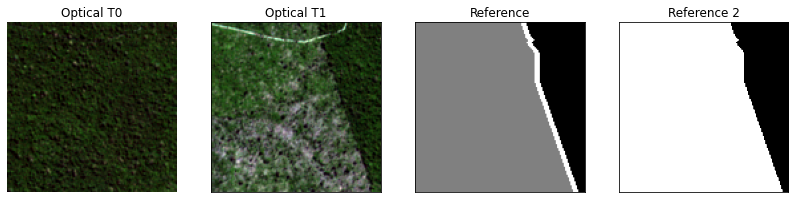

In [29]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [30]:
if config["training"] == True:
    trainer.getGenerators()


In [31]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [32]:
if config["training"] == True:
    print(trainer.path_exp)

D:/Jorge/datasets/deforestation/experiments/exp173


In [33]:
if config["training"] == True:
    print(trainer.channels)

21


In [34]:
if config["training"] == True:
    print(trainer.image_stack.shape)

(17730, 9200, 21)


In [35]:
# trainer.weights = [0.01, 0.99, 0]
trainer.weights

[0.1, 0.9, 0]

### Evidential metrics

In [36]:
if config["training"] == True:
    trainer.train()

time:  0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (Dropout)             (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
_____________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
self.global_step 0.0
alpha Tensor("loss/add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("loss/truediv:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_6:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_7:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_5:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_12:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("loss/add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("loss/truediv:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_6:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_7:0", shape=(None, 128, 128, 3), dtype=float

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


351/351 [==============================] - 32s 90ms/step - loss: 0.0612 - accuracy: 0.9021 - KL_term: 0.0182 - loglikelihood_term: 0.1654 - evidential_success: 31.4771 - evidential_fail: 10.2423 - acc: 0.9020 - annealing_coef: 0.0933 - global_step_get: 350.0000 - annealing_step_get: 3750.0000 - val_loss: 0.0768 - val_accuracy: 0.8883 - val_KL_term: 0.0383 - val_loglikelihood_term: 0.1895 - val_evidential_success: 30.7747 - val_evidential_fail: 8.4265 - val_acc: 0.8896 - val_annealing_coef: 0.1867 - val_global_step_get: 700.0000 - val_annealing_step_get: 3750.0000

Epoch 00002: val_loss improved from 0.10257 to 0.07681, saving model to D:/Jorge/datasets/deforestation/experiments/exp173/models\resunet_0.h5
Epoch 3/100
self.global_step 700.0
351/351 [==============================] - 32s 91ms/step - loss: 0.0565 - accuracy: 0.9127 - KL_term: 0.0189 - loglikelihood_term: 0.1507 - evidential_success: 37.7776 - evidential_fail: 8.1296 - acc: 0.9126 - annealing_coef: 0.1400 - global_step_get:

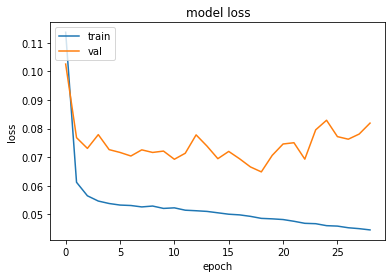

In [37]:
if config["training"] == True:
    trainer.plotHistory()


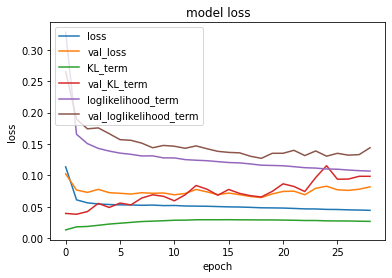

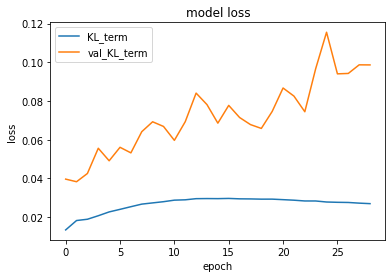

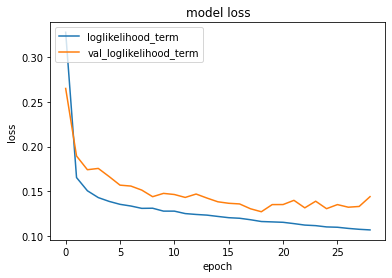

In [38]:
if config["training"] == True:
    trainer.plotLossTerms()

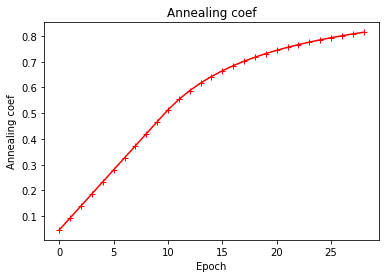

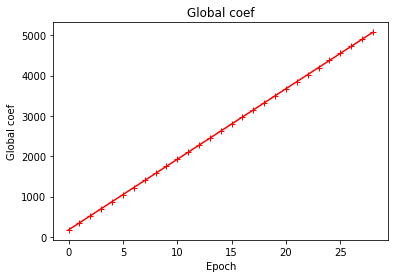

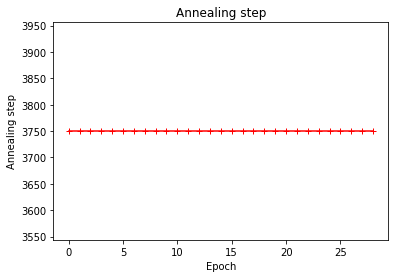

In [39]:
if config["training"] == True:
    trainer.plotAnnealingCoef()

In [40]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

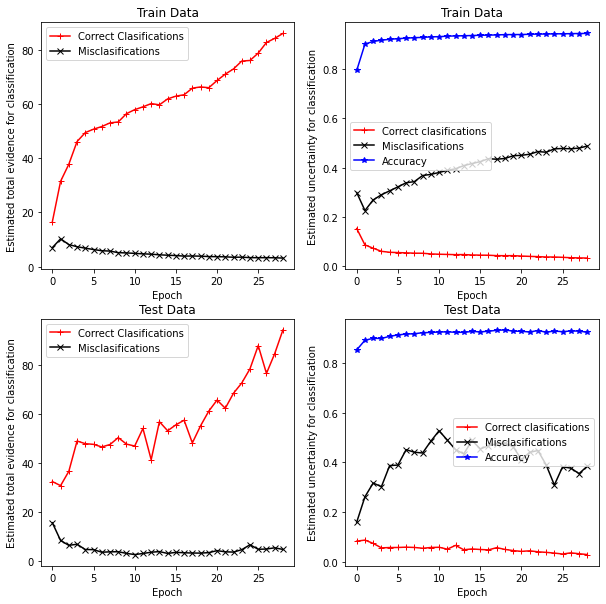

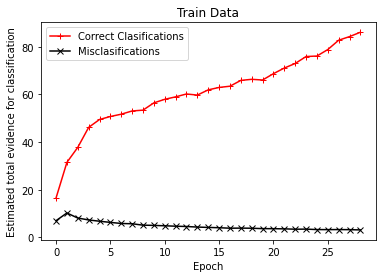

In [41]:
if config["training"] == True:
    draw_EDL_results(trainer.class_n, trainer.history.history)

    plt.figure(5)
    plt.plot(trainer.history.history['evidential_success'],c='r',marker='+')
    plt.plot(trainer.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [42]:
trainer.image_stack.shape

(17730, 9200, 21)

In [43]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [44]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]

In [45]:
trainer.image_stack.shape

(17730, 9200, 21)

In [46]:
trainer.setPadding()

-30.0 -16.0


In [47]:
trainer.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp173/models/resunet_0.h5'


time:  0


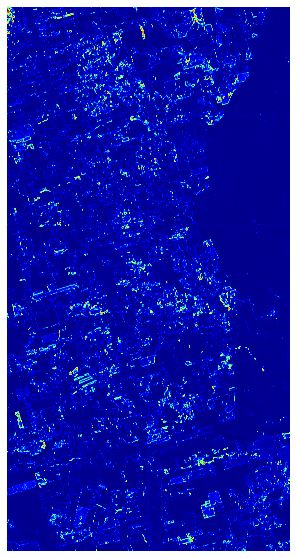

In [48]:
trainer.logger.plotFigure(trainer.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [49]:
trainer.loadPredictedProbabilities()


In [50]:
trainer.prob_rec.shape

(17760, 9216)

In [51]:
trainer.getMeanProb()

In [52]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0046187807
    np.mean(value): 0.030163825
    np.max(value): 0.96274173


In [53]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

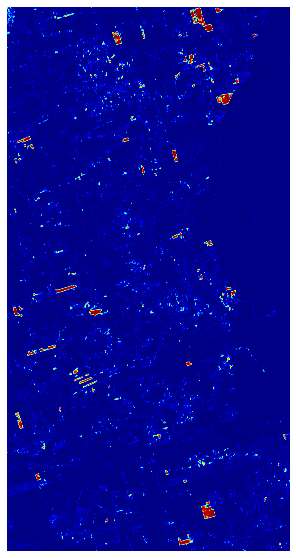

In [54]:
trainer.unpadMeanProb()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

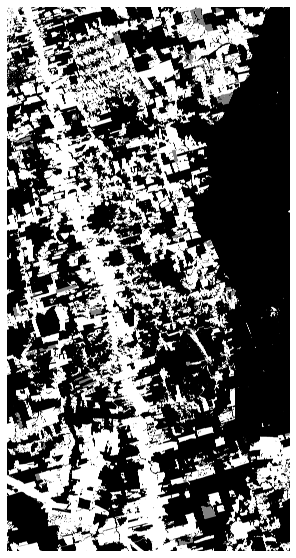

In [55]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [56]:
trainer.squeezeLabel()

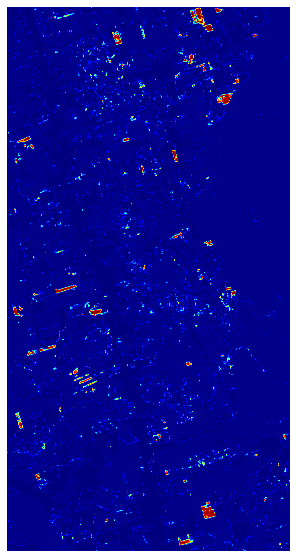

In [57]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [58]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.022795338
    np.max(value): 0.96274173


In [59]:
print(trainer.label_mask.shape)

(17730, 9200)


In [60]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [61]:
trainer.getMAP()

90.16


In [62]:
trainer.prob_rec.shape

(17760, 9216)

In [63]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(17760, 9216, 1)


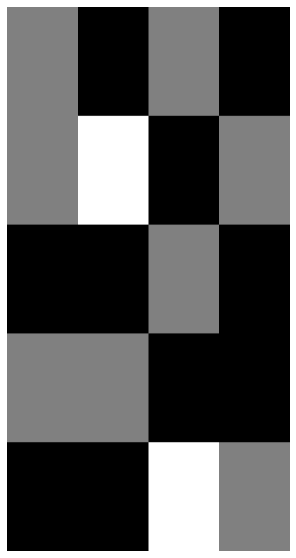

In [64]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [65]:
trainer.getLabelCurrentDeforestation()

In [66]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([161233790,   1882210], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [67]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [68]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([161233790,   1882210], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161411932,   1704068], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162937858,    178142], dtype=int64))


In [69]:
trainer.calculateMetrics()

ic| self.f1: 86.03, self.precision: 88.85, self.recall: 83.38


In [70]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9431090,)
ic| f1_val: 85.47
    precision_val: 83.29
    recall_val: 87.77
    mAP_val: 89.49


In [71]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [72]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162578078,    537922], dtype=int64))


In [73]:
'''

import types

trainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [74]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


In [75]:
predicted_unpad_to_show = trainer.predicted_unpad.copy()

predicted_unpad_to_show[trainer.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [76]:
predicted_unpad_to_show.shape

(17730, 9200)

In [77]:

'''
trainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

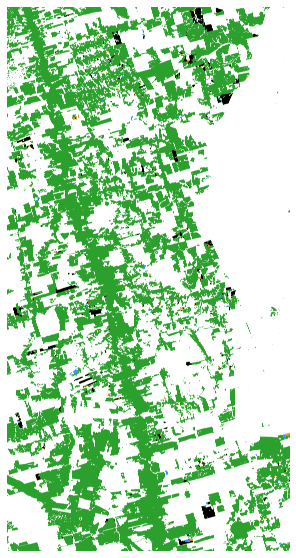

In [78]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [79]:
trainer.setUncertainty()

In [80]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54147698,)


In [81]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0
    np.mean(value): 0.042114858
    np.max(value): 1.0


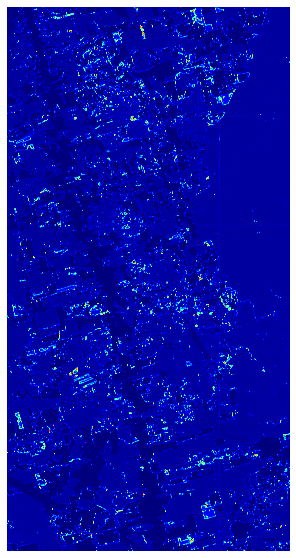

In [82]:
trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


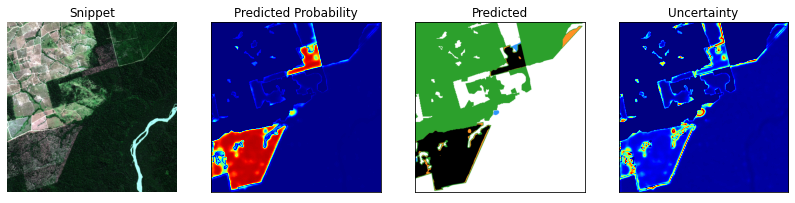

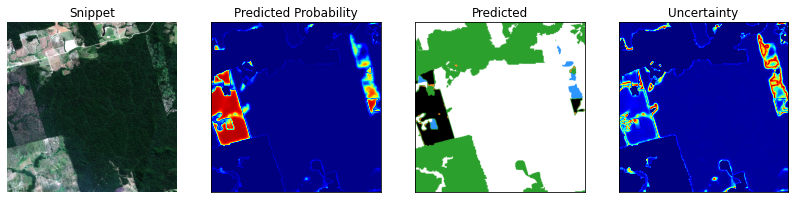

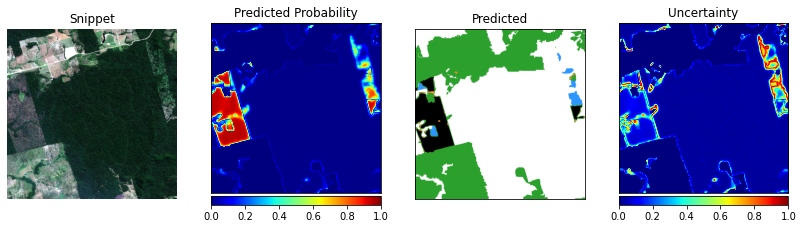

In [83]:
trainer.logger.plotCropSample(trainer)

In [84]:
trainer.logger.getStats(trainer.uncertainty)

ic| np.min(value): 0.013856342
    np.mean(value): 0.061989293
    np.max(value): 1.0


In [85]:
from src import metrics as _metrics

def getUncertaintyAAValues(self):



    # self.threshold_list = [0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36]

    # self.threshold_list = [0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.25, 0.27, 0.3, 0.34, 0.36, np.max(uncertainty)-0.003]
    if self.config['uncertainty_method'] == "pred_entropy":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "pred_var":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.13/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.0015, np.max(self.uncertainty)-0.0008]
    elif self.config['uncertainty_method'] == "MI":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*0.235/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.003, np.max(self.uncertainty)-0.0015]
    elif self.config['uncertainty_method'] == "KL":
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(self.uncertainty)-0.006, np.max(self.uncertainty)-0.003]
    elif self.config['uncertainty_method'] == "evidential":
            # self.threshold_list = [0.015, 0.03, 0.04]
            self.threshold_list = [0.0025, 0.005, 0.0075, 0.01, 0.015, 0.025, 0.05, 0.08, 0.1, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36]
            self.threshold_list = [ 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            self.threshold_list = [0.13, 0.15, 0.2, 0.225, 
                    0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]

            # self.threshold_list = [ 0.15, 0.2,  
            #          0.3, 0.35, 0.4, 0.5, 0.6, 0.7]

            # self.threshold_list = [0.015,0.1, 0.2, 0.27, 0.36, 0.45, 0.55, 0.65]

            # self.threshold_list = [x*1.0/0.36 for x in self.threshold_list] + [np.max(uncertainty)-0.006, np.max(uncertainty)-0.003]
                    
            # self.threshold_list = np.linspace(np.min(uncertainty) + 0.0015, np.max(uncertainty) - 0.0015, 19)
    print(self.threshold_list)
    self.loadThresholdMetrics = False
    if self.loadThresholdMetrics == False:
            # self.threshold_list = [0.1]
            # y_test
            ic(self.uncertainty.shape, self.label_mask_current_deforestation_test.shape)

            metrics_values = _metrics.getAA_Recall(self.uncertainty, 
                    self.label_mask_current_deforestation_test, 
                    self.predicted_test, self.threshold_list)

            # ic(metrics_values)


    self.m = {'precision_L': metrics_values[:,0],
            'recall_L': metrics_values[:,1],
            'recall_Ltotal': metrics_values[:,2],
            'AA': metrics_values[:,3],
            'precision_H': metrics_values[:,4],
            'recall_H': metrics_values[:,5]}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])

In [86]:

import types

trainer.getUncertaintyAAValues = types.MethodType(getUncertaintyAAValues, trainer)


In [87]:
trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54147698,)
    self.label_mask_current_deforestation_test.shape: (54147698,)


[0.13, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.13
(50097636,) (50097636,)


ic| label_current_deforestation_test_classified_incorrect.shape: (4050062,)
    predicted_test_classified_incorrect.shape: (4050062,)


cm_correct [[49806418      202]
 [   16742   274274]]


ic| TP_H + FN_H + FP_H + TN_H: 4050062
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 4050062
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[3526167   76978]
 [ 105868  341049]]
[0.99926405 0.94247052 0.37167873 0.07479657 0.815854   0.76311485]
threshold 0.15
(50401261,) (50401261,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3746437,)
    predicted_test_classified_incorrect.shape: (3746437,)


cm_correct [[50070117      494]
 [   18073   312577]]


ic| TP_H + FN_H + FP_H + TN_H: 3746437
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 3746437
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[3262468   76686]
 [ 104537  302746]]
[0.99842208 0.945341   0.42358453 0.06918922 0.79789264 0.7433308 ]
threshold 0.2
(50964065,) (50964065,)


ic| label_current_deforestation_test_classified_incorrect.shape: (3183633,)
    predicted_test_classified_incorrect.shape: (3183633,)


cm_correct [[50567734     2244]
 [   21073   373014]]


ic| TP_H + FN_H + FP_H + TN_H: 3183633
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 3183633
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2764851   74936]
 [ 101537  242309]]
[0.99402011 0.94652704 0.50548492 0.05879535 0.76379139 0.70470211]
threshold 0.225
(51187580,) (51187580,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2960118,)
    predicted_test_classified_incorrect.shape: (2960118,)


cm_correct [[50767236     3736]
 [   22521   394087]]


ic| TP_H + FN_H + FP_H + TN_H: 2960118
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2960118
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2565349   73444]
 [ 100089  221236]]
[0.99060889 0.94594199 0.53404171 0.05466748 0.75076693 0.68851163]
threshold 0.25
(51390679,) (51390679,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2757019,)
    predicted_test_classified_incorrect.shape: (2757019,)


cm_correct [[50948617     5714]
 [   23821   412527]]


ic| TP_H + FN_H + FP_H + TN_H: 2757019
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2757019
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2383968   71466]
 [  98789  202796]]
[0.98633802 0.94540825 0.55903043 0.05091664 0.73942435 0.67243397]
threshold 0.27
(51542925,) (51542925,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2604773,)
    predicted_test_classified_incorrect.shape: (2604773,)


cm_correct [[51083710     8263]
 [   24737   426215]]


ic| TP_H + FN_H + FP_H + TN_H: 2604773
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2604773
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2248875   68917]
 [  97873  189108]]
[0.98098178 0.94514494 0.57757954 0.04810496 0.73290573 0.65895652]
threshold 0.3
(51755833,) (51755833,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2391865,)
    predicted_test_classified_incorrect.shape: (2391865,)


cm_correct [[51271397    12721]
 [   26114   445601]]


ic| TP_H + FN_H + FP_H + TN_H: 2391865
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2391865
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2061188   64459]
 [  96496  169722]]
[0.9722444  0.9446403  0.60385021 0.04417298 0.7247471  0.63753014]
threshold 0.34
(52010889,) (52010889,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2136809,)
    predicted_test_classified_incorrect.shape: (2136809,)


cm_correct [[51494331    19132]
 [   27835   469591]]


ic| TP_H + FN_H + FP_H + TN_H: 2136809
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2136809
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[1838254   58048]
 [  94775  145732]]
[0.96085308 0.94404193 0.63635994 0.0394626  0.71514378 0.60593663]
threshold 0.36
(52129862,) (52129862,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2017836,)
    predicted_test_classified_incorrect.shape: (2017836,)


cm_correct [[51598066    22181]
 [   28676   480939]]


ic| TP_H + FN_H + FP_H + TN_H: 2017836
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2017836
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[1734519   54999]
 [  93934  134384]]
[0.9559131  0.94373007 0.65173803 0.03726541 0.70958851 0.58858259]
threshold 0.45
(52610008,) (52610008,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1537690,)
    predicted_test_classified_incorrect.shape: (1537690,)
ic

cm_correct [[52016475    35072]
 [   32623   525838]]
cm_incorrect [[1316110   42108]
 [  89987   89485]]


| TP_H + FN_H + FP_H + TN_H: 1537690
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1537690
    len(label_mask_current_deforestation_test): 54147698


[0.93747303 0.9415841  0.71258231 0.02839807 0.68001337 0.49860145]
threshold 0.55
(53019774,) (53019774,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1127924,)
    predicted_test_classified_incorrect.shape: (1127924,)
ic| TP_H + FN_H + FP_H + TN_H: 1127924
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1127924
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52367842    50289]
 [   36941   564702]]
cm_incorrect [[964743  26891]
 [ 85669  50621]]
[0.91822807 0.9385998  0.76524834 0.02083051 0.65307307 0.37142123]
threshold 0.65
(53332776,) (53332776,)


ic| label_current_deforestation_test_classified_incorrect.shape: (814922,)
    predicted_test_classified_incorrect.shape: (814922,)
ic| TP_H + FN_H + FP_H + TN_H: 814922
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 814922
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52635540    63518]
 [   41415   592303]]
cm_incorrect [[697045  13662]
 [ 81195  23020]]
[0.90314735 0.93464759 0.80265146 0.01504998 0.62755575 0.22088951]
threshold 0.8
(53702091,) (53702091,)


ic| label_current_deforestation_test_classified_incorrect.shape: (445607,)
    predicted_test_classified_incorrect.shape: (445607,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 445607
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 445607
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52945425    77180]
 [   64163   615323]]
cm_incorrect [[387160      0]
 [ 58447      0]]
[0.88854922 0.90557127 0.8338467  0.00822947        nan 0.        ]


In [88]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54147698,)
    self.label_mask_current_deforestation_test.shape: (54147698,)


threshold 0.13
(54147698,) (54147698,)
cm_audited [[53409563      202]
 [   16742   721191]]
[0.99971999 0.9773123 ]
threshold 0.15
(54147698,) (54147698,)
cm_audited [[53409271      494]
 [   18073   719860]]
[0.99931423 0.97550862]
threshold 0.2
(54147698,) (54147698,)
cm_audited [[53407521     2244]
 [   21073   716860]]
[0.99687945 0.97144321]
threshold 0.225
(54147698,) (54147698,)
cm_audited [[53406029     3736]
 [   22521   715412]]
[0.99480496 0.96948097]
threshold 0.25
(54147698,) (54147698,)
cm_audited [[53404051     5714]
 [   23821   714112]]
[0.99206197 0.96771929]
threshold 0.27
(54147698,) (54147698,)
cm_audited [[53401502     8263]
 [   24737   713196]]
[0.98854682 0.96647799]
threshold 0.3
(54147698,) (54147698,)
cm_audited [[53397044    12721]
 [   26114   711819]]
[0.98244265 0.96461196]
threshold 0.34
(54147698,) (54147698,)
cm_audited [[53390633    19132]
 [   27835   710098]]
[0.97376411 0.96227977]
threshold 0.36
(54147698,) (54147698,)
cm_audited [[53387584    2

ic| metric_values_audited: array([[0.99971999, 0.9773123 ],
                                  [0.99931423, 0.97550862],
                                  [0.99687945, 0.97144321],
                                  [0.99480496, 0.96948097],
                                  [0.99206197, 0.96771929],
                                  [0.98854682, 0.96647799],
                                  [0.98244265, 0.96461196],
                                  [0.97376411, 0.96227977],
                                  [0.9696748 , 0.9611401 ],
                                  [0.95262986, 0.95579138],
                                  [0.93306233, 0.9499399 ],
                                  [0.91642764, 0.94387702],
                                  [0.89722352, 0.91305037]])


cm_audited [[53332585    77180]
 [   64163   673770]]
[0.89722352 0.91305037]


In [89]:
trainer.setPlotLimsForUncertaintyAA()

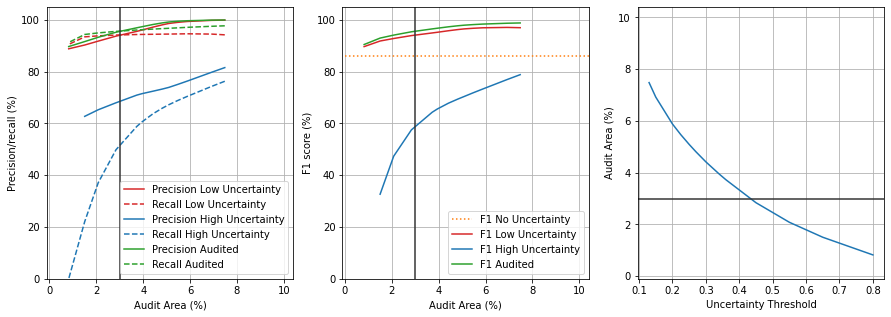

In [90]:
trainer.plotUncertaintyAA()

In [91]:
trainer.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484
(52258908,) (52258908,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1888790,)
    predicted_test_classified_incorrect.shape: (1888790,)


cm_correct [[51710951    25517]
 [   29636   492804]]


ic| TP_H + FN_H + FP_H + TN_H: 1888790
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1888790
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[1621634   51663]
 [  92974  122519]]
[0.95076989 0.94327387 0.66781673 0.03488218 0.70339645 0.56855211]
0.6176798867836452
threshold 0.6176798867836452
(53239873,) (53239873,)


ic| label_current_deforestation_test_classified_incorrect.shape: (907825,)
    predicted_test_classified_incorrect.shape: (907825,)
ic| TP_H + FN_H + FP_H + TN_H: 907825
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 907825
    len(label_mask_current_deforestation_test): 54147698


cm_correct [[52556643    59379]
 [   39785   584066]]
cm_incorrect [[775942  17801]
 [ 82825  31257]]
[0.90771705 0.93622676 0.7914892  0.01676572 0.63714379 0.27398713]
0.23685977356729035
threshold 0.23685977356729035
(51285995,) (51285995,)


ic| label_current_deforestation_test_classified_incorrect.shape: (2861703,)
    predicted_test_classified_incorrect.shape: (2861703,)


cm_correct [[50855159     4622]
 [   23147   403067]]


ic| TP_H + FN_H + FP_H + TN_H: 2861703
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 2861703
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[2477426   72558]
 [  99463  212256]]
[0.98866293 0.9456916  0.54621083 0.05284995 0.74524426 0.68092096]
0.45750587539724097
threshold 0.45750587539724097
(52645015,) (52645015,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1502683,)
    predicted_test_classified_incorrect.shape: (1502683,)
ic

cm_correct [[52046538    36275]
 [   32911   529291]]
cm_incorrect [[1286047   40905]
 [  89699   86032]]


| TP_H + FN_H + FP_H + TN_H: 1502683
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1502683
    len(label_mask_current_deforestation_test): 54147698


[0.93586071 0.94146054 0.71726159 0.02775156 0.67775353 0.48956644]
0.4596971525132963
threshold 0.4596971525132963
(52655110,) (52655110,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1492588,)
    predicted_test_classified_incorrect.shape: (1492588,)
ic

cm_correct [[52055188    36608]
 [   32995   530319]]
cm_incorrect [[1277397   40572]
 [  89615   85004]]


| TP_H + FN_H + FP_H + TN_H: 1492588
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1492588
    len(label_mask_current_deforestation_test): 54147698


[0.93542731 0.94142698 0.71865467 0.02756512 0.67691279 0.48679697]
0.4311964031819474
threshold 0.4311964031819474
(52518670,) (52518670,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1629028,)
    predicted_test_classified_incorrect.shape: (1629028,)
ic

cm_correct [[51937544    32341]
 [   31799   516986]]
cm_incorrect [[1395041   44839]
 [  90811   98337]]


| TP_H + FN_H + FP_H + TN_H: 1629028
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1629028
    len(label_mask_current_deforestation_test): 54147698


[0.94112614 0.94205563 0.70058664 0.0300849  0.686826   0.51989447]
0.41252732165908645
threshold 0.41252732165908645
(52422901,) (52422901,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1724797,)
    predicted_test_classified_incorrect.shape: (1724797,)


cm_correct [[51854201    29719]
 [   30964   508017]]


ic| TP_H + FN_H + FP_H + TN_H: 1724797
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1724797
    len(label_mask_current_deforestation_test): 54147698


cm_incorrect [[1478384   47461]
 [  91646  107306]]
[0.9447331  0.94255085 0.68843242 0.03185356 0.69333902 0.53935623]
0.43390093923813866
threshold 0.43390093923813866
(52531998,) (52531998,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1615700,)
    predicted_test_classified_incorrect.shape: (1615700,)
ic

cm_correct [[51949087    32700]
 [   31916   518295]]
cm_incorrect [[1383498   44480]
 [  90694   97028]]


| TP_H + FN_H + FP_H + TN_H: 1615700
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1615700
    len(label_mask_current_deforestation_test): 54147698


[0.94065282 0.94199316 0.70236051 0.02983876 0.68567148 0.51687069]
0.4300953825951522
threshold 0.4300953825951522
(52513338,) (52513338,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1634360,)
    predicted_test_classified_incorrect.shape: (1634360,)
ic

cm_correct [[51932898    32186]
 [   31756   516498]]
cm_incorrect [[1399687   44994]
 [  90854   98825]]


| TP_H + FN_H + FP_H + TN_H: 1634360
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1634360
    len(label_mask_current_deforestation_test): 54147698


[0.94133964 0.94207794 0.69992533 0.03018337 0.68714843 0.52101181]
0.4320921860038556
threshold 0.4320921860038556
(52523196,) (52523196,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624502,)
    predicted_test_classified_incorrect.shape: (1624502,)
ic

cm_correct [[51941475    32467]
 [   31840   517414]]
cm_incorrect [[1391110   44713]
 [  90770   97909]]


| TP_H + FN_H + FP_H + TN_H: 1624502
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1624502
    len(label_mask_current_deforestation_test): 54147698


[0.94095632 0.94203046 0.70116664 0.03000131 0.68649297 0.51891837]
0.43233862328996914
threshold 0.43233862328996914
(52524379,) (52524379,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1623319,)
    predicted_test_classified_incorrect.shape: (1623319,)
ic

cm_correct [[51942513    32491]
 [   31852   517523]]
cm_incorrect [[1390072   44689]
 [  90758   97800]]


| TP_H + FN_H + FP_H + TN_H: 1623319
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1623319
    len(label_mask_current_deforestation_test): 54147698


[0.94092696 0.94202139 0.70131435 0.02997946 0.68636877 0.5186733 ]
0.4319553644923658
threshold 0.4319553644923658
(52522510,) (52522510,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1625188,)
    predicted_test_classified_incorrect.shape: (1625188,)
ic

cm_correct [[51940895    32449]
 [   31834   517332]]
cm_incorrect [[1391690   44731]
 [  90776   97991]]


| TP_H + FN_H + FP_H + TN_H: 1625188
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1625188
    len(label_mask_current_deforestation_test): 54147698


[0.94097832 0.9420321  0.70105552 0.03001398 0.68658651 0.51911086]
0.432127785320172
threshold 0.432127785320172
(52523372,) (52523372,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624326,)
    predicted_test_classified_incorrect.shape: (1624326,)
ic

cm_correct [[51941629    32469]
 [   31844   517430]]
cm_incorrect [[1390956   44711]
 [  90766   97893]]


| TP_H + FN_H + FP_H + TN_H: 1624326
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1624326
    len(label_mask_current_deforestation_test): 54147698


[0.94095461 0.94202529 0.70118832 0.02999806 0.68646742 0.51888858]
0.43205884626155944
threshold 0.43205884626155944
(52523044,) (52523044,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624654,)
    predicted_test_classified_incorrect.shape: (1624654,)


cm_correct [[51941342    32463]
 [   31839   517400]]


ic| TP_H + FN_H + FP_H + TN_H: 1624654
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1624654
    len(label_mask_current_deforestation_test): 54147698
ic| self.threshold_optimal: 0.4320921860038556


cm_incorrect [[1391243   44717]
 [  90771   97923]]
[0.94096166 0.9420307  0.70114767 0.03000412 0.68650449 0.51895132]


In [92]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.4320921860038556
(52523196,) (52523196,)


ic| label_current_deforestation_test_classified_incorrect.shape: (1624502,)
    predicted_test_classified_incorrect.shape: (1624502,)
ic

cm_correct [[51941475    32467]
 [   31840   517414]]
cm_incorrect [[1391110   44713]
 [  90770   97909]]


| TP_H + FN_H + FP_H + TN_H: 1624502
    len(label_mask_current_deforestation_test): 54147698
ic| TP_H + FN_H + FP_H + TN_H: 1624502
    len(label_mask_current_deforestation_test): 54147698


[0.94095632 0.94203046 0.70116664 0.03000131 0.68649297 0.51891837]
threshold 0.4320921860038556
(54147698,) (54147698,)


ic| self.m_optimal: {'AA': array([0.03000131]),
                     'f1': 86.03,
                     'f1_H': array([0.59105768]),
                     'f1_L': array([0.94149308]),
                     'precision_H': array([0.68649297]),
                     'precision_L': array([0.94095632]),
                     'recall_H': array([0.51891837]),
                     'recall_L': array([0.94203046]),
                     'recall_Ltotal': array([0.70116664])}
ic| self.m_audited_optimal: {'f1': array([0.95644612]),
                             'precision': array([0.95604013]),
                             'recall': array([0.95685245])}


cm_audited [[53377298    32467]
 [   31840   706093]]
[0.95604013 0.95685245]


{'metrics': {'precision_L': array([0.94095632]),
  'recall_L': array([0.94203046]),
  'recall_Ltotal': array([0.70116664]),
  'AA': array([0.03000131]),
  'precision_H': array([0.68649297]),
  'recall_H': array([0.51891837]),
  'f1_L': array([0.94149308]),
  'f1_H': array([0.59105768]),
  'f1': 86.03},
 'metrics_audited': {'precision': array([0.95604013]),
  'recall': array([0.95685245]),
  'f1': array([0.95644612])},
 'exp': 173}